# Exploration: COVID-19 deaths and confirmed cases

This notebook tries to recover clusters of countries whose time series of deaths as a result of COVID-19 are visually similar. Data is read in from the Johns Hopkins [coronavirus GitHub repository](https://github.com/CSSEGISandData/COVID-19). Three measures of time series similarity are considered:  

1. Mean shift similarity. 
2. Frechet distance between piecewise-constant skeletons. 
3. Frechet distance between piecewise-linear skeletons. 

## Setup

In [3]:
source("../scripts/build_datasets.R")
source("../scripts/frechet_dist_skeleton.R")
source("../scripts/mean_shift_similarity.R")
source("../scripts/cluster_process.R")

Warning message:
"Columns [Founded] seem to have no data and are removed. Use rm_nodata_cols = F to suppress this behavior"


In [4]:
COVID <- COVID19.global()

### EDA

As with the previous notebook all time series in the panel are visually similar (in fact, ultimately all the tie series will end up looking like logistic curves) - still, at the time this notebook was run there are obvious differences. 

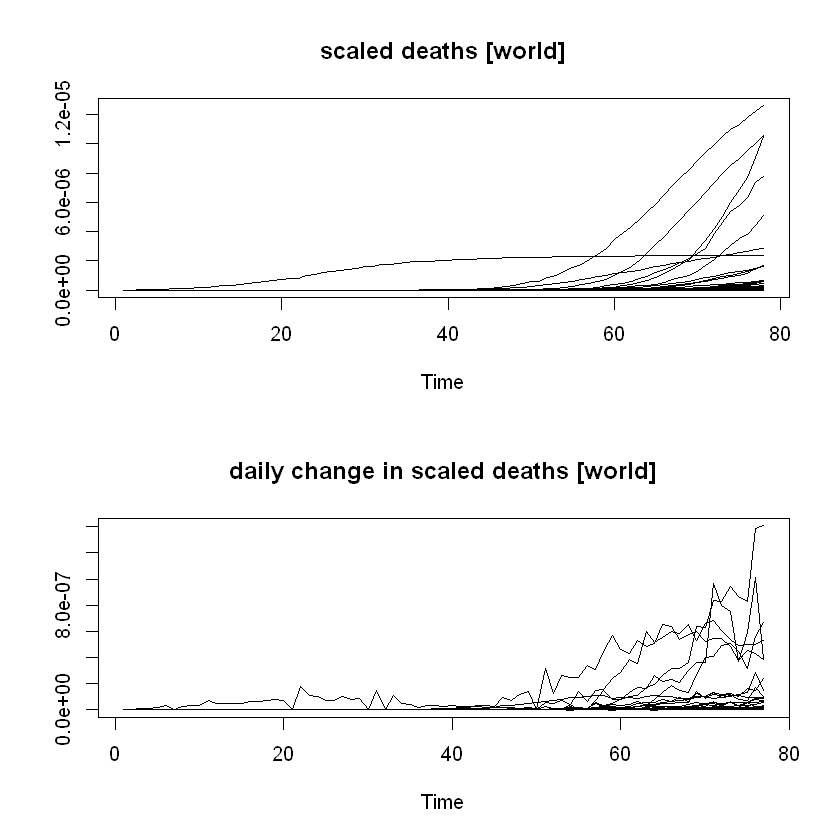

In [5]:
scaled.deaths <- data.frame(sapply(names(COVID$deaths), function(x) 
  subset(COVID$deaths, select = x)/countries.population$Population[which.min(stringdist(countries.population$Country,x))]))
names(scaled.deaths) <- names(COVID$deaths)

par(mfrow = c(2,1))
ts.plot(scaled.deaths, main = "scaled deaths [world]")
ts.plot(apply(scaled.deaths,2,diff), main = "daily change in scaled deaths [world]")

Clearly other parametric methods are obviously better suited finding similar countries ... still fit from piecewise linear approximation is good... 

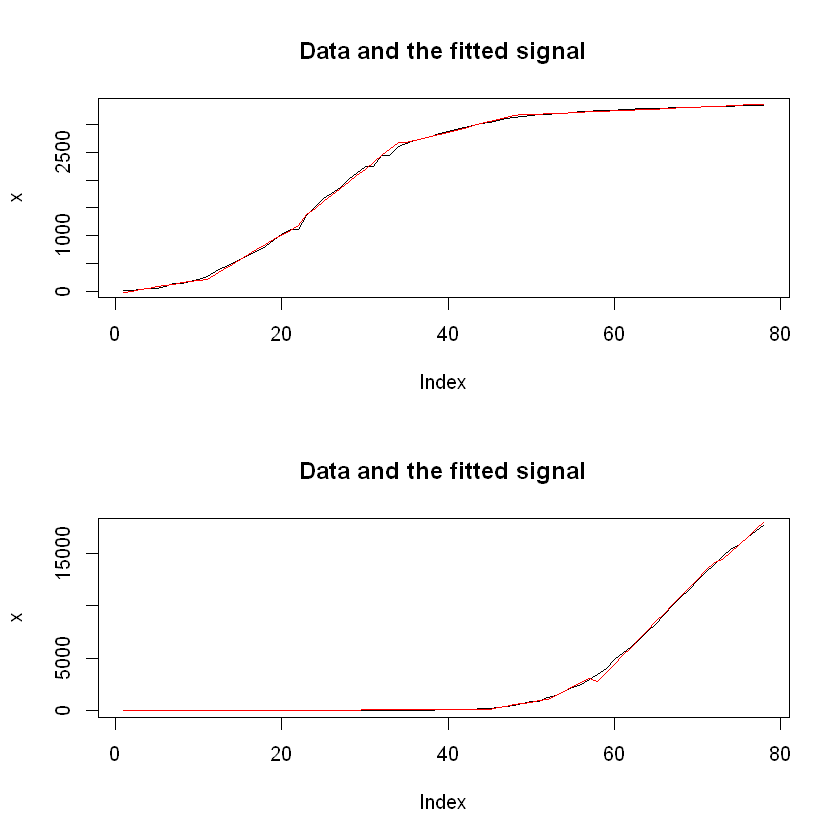

In [71]:
library(not); par(mfrow = c(2,1))
plot(not(COVID$deaths$China, contrast = "pcwsLinMean"))
plot(not(COVID$deaths$Italy, contrast = "pcwsLinMean"))

In [98]:
features(not(COVID$deaths$Italy, contrast = "pcwsLinMean"))$cpt

[1] 44 51 57 72

## Mean shift similarity

Inference on a single mean shift is not a good idea...

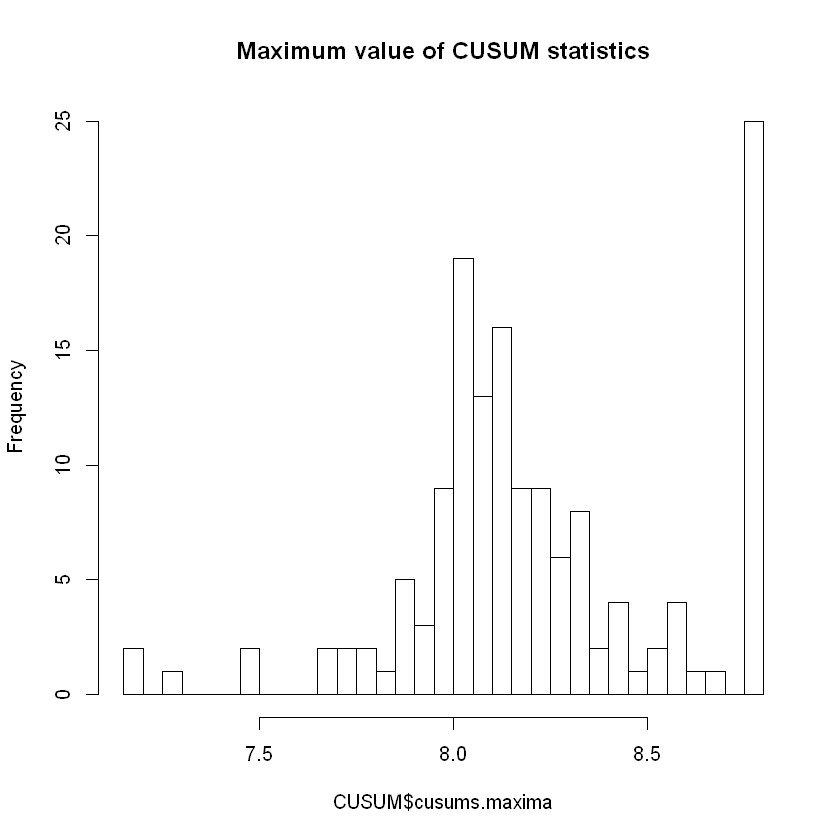

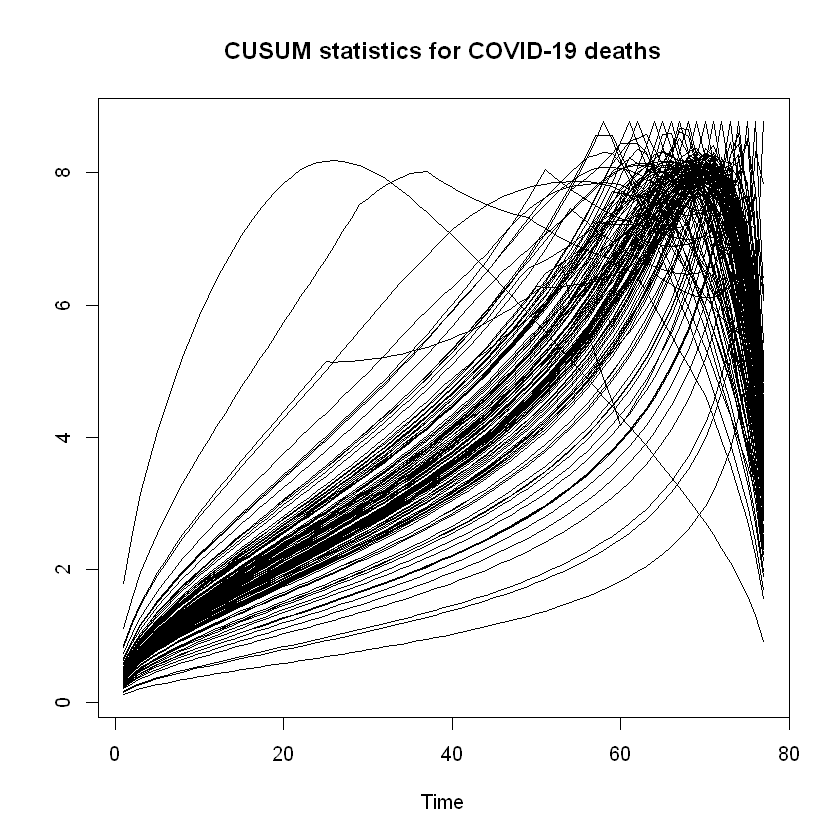

In [6]:
CUSUM <- cusum.locs(COVID$deaths)
hist(CUSUM$cusums.maxima, 50, main = "Maximum value of CUSUM statistics")
ts.plot(CUSUM$cusums, main = "CUSUM statistics for COVID-19 deaths")

## Piecewise-constant skeleton

[1] "fitting time series skeletons (in parallel)"
[1] "calculating distance matrix..."


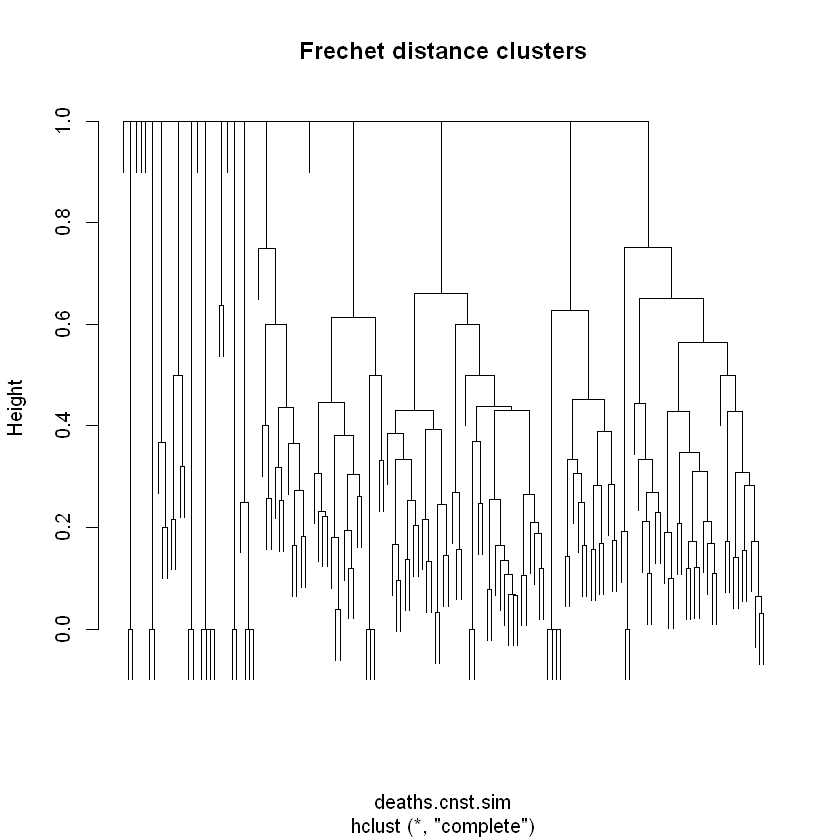

In [7]:
deaths.cnst.sim <- skeleton.similarity(COVID$deaths, set.contrast = "pcwsConstMean", parallel.comp = TRUE)
deaths.cnst.hc <- hclust(deaths.cnst.sim)
plot(deaths.cnst.hc, main = "Frechet distance clusters", labels = FALSE)

### Do clusters correspond to countries which are close geographically? 

Typically no.. 

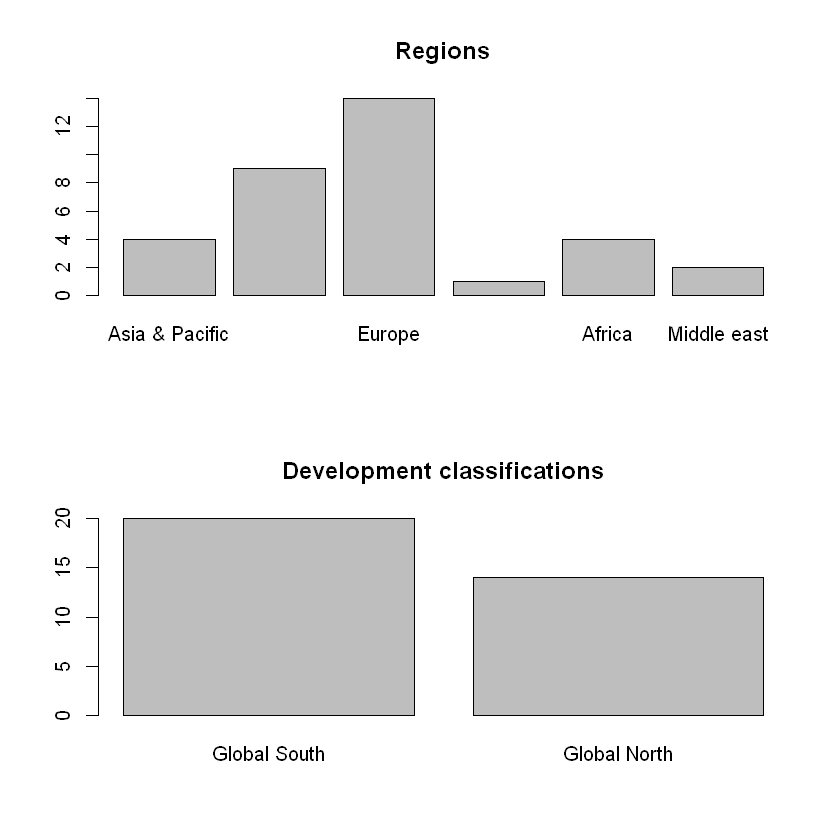

In [76]:
deaths.cnst.clusters <- country.cluster.info(deaths.cnst.hc, h = 0.8, countries.info = countries.info)
country.cluster.boxplot(subset(deaths.cnst.clusters$cluster.info, clusters == 1))

However smaller clusters tend to be at least within the same continent. 

In [88]:
small.clusters <- subset(deaths.cnst.clusters$cluster.counts, count %in% 2:3)$cluster
subset(deaths.cnst.clusters$cluster.info, clusters %in% small.clusters)

,Country,Region,Development,clusters
,<named list>,<named list>,<named list>,<int>
Brunei,Burundi,Africa,Global South,8
Costa Rica,Costa Rica,South/Latin America,Global South,10
Diamond Princess,Dominica,South/Latin America,Global South,10
Gambia,Gambia,Africa,Global South,13
Jordan,Jordan,Middle east,Global South,15
Latvia,Latvia,Europe,Global North,16
Mauritania,Mauritania,Arab States,Global South,15
Suriname,Suriname,South/Latin America,Global South,16
United Arab Emirates,United Arab Emirates,Middle east,Global South,15


### Are clustered time series visually similar? 

Yes in general... 

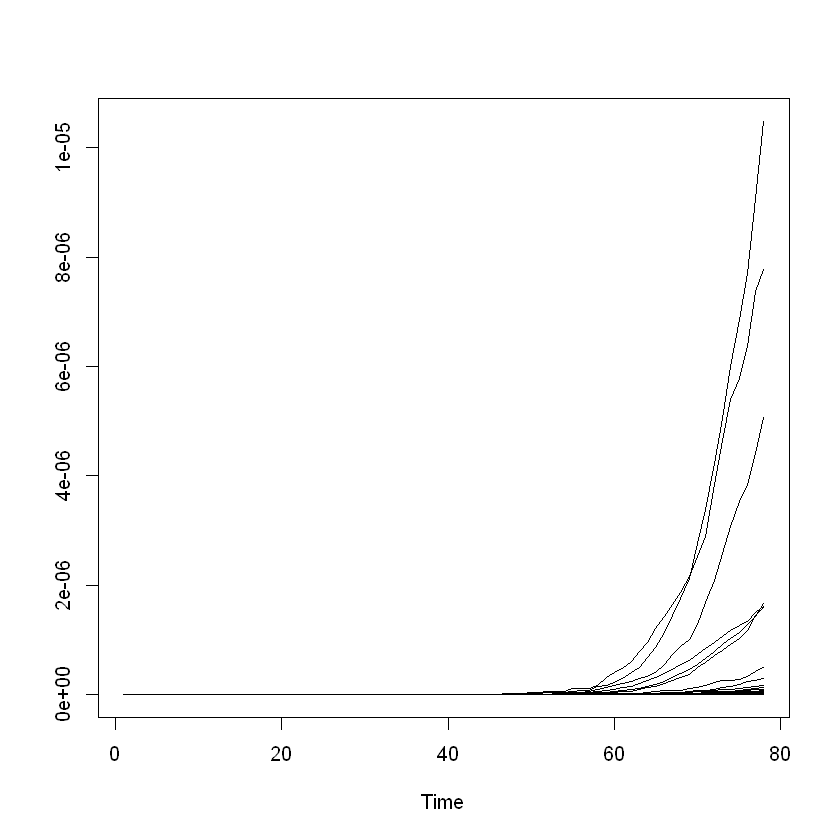

In [49]:
cluster.names <- rownames(subset(deaths.cnst.clusters$cluster.info, clusters == 1))
ts.plot(subset(scaled.deaths, select = cluster.names))

### Investigating single clusters

Counties in cluster of one: Antigua and Barbuda China Gabon Malta Nicaragua Somalia Malawi

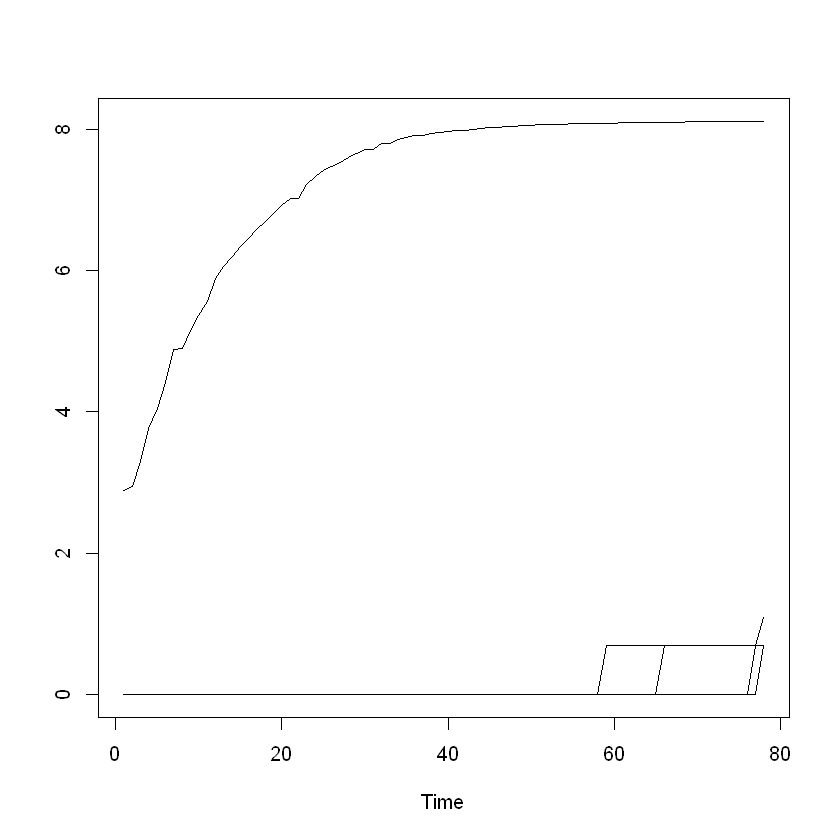

In [95]:
single.entry.names <- rownames(subset(deaths.cnst.clusters$cluster.info, clusters %in% single.entry))
cat("Counties in cluster of one:",t(single.entry.names))
ts.plot(subset(log(COVID$deaths + 1), select = single.entry.names))